In [1]:
import torch
import torch.nn as nn

In [2]:
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 15.4 MB/s eta 0:00:00 0:00:01


In [3]:
!nvidia-smi

Mon Mar 11 20:24:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-40GB'

### MNIST

In [43]:
# download mnist 
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

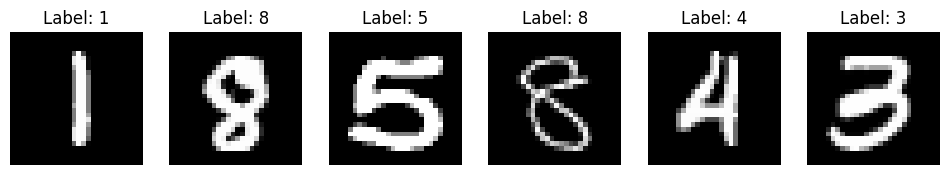

In [44]:
import matplotlib.pyplot as plt

import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = labels[i].item()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [7]:
# define model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# train model

import torch.optim as optim
import torch.nn.functional as F

epochs = 10
print_every_n_batches = 50

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

accuracies = []
losses = []

for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                
                running_accuracy = running_loss = 0.0

[1,    50] loss: 1.645, accuracy: 0.486
[1,   100] loss: 0.517, accuracy: 0.837
[1,   150] loss: 0.359, accuracy: 0.894
[1,   200] loss: 0.293, accuracy: 0.914
[1,   250] loss: 0.230, accuracy: 0.931
[1,   300] loss: 0.161, accuracy: 0.952
[1,   350] loss: 0.139, accuracy: 0.952
[1,   400] loss: 0.142, accuracy: 0.959
[1,   450] loss: 0.120, accuracy: 0.962
[2,    50] loss: 0.098, accuracy: 0.971
[2,   100] loss: 0.099, accuracy: 0.970
[2,   150] loss: 0.107, accuracy: 0.965
[2,   200] loss: 0.079, accuracy: 0.975
[2,   250] loss: 0.085, accuracy: 0.971
[2,   300] loss: 0.092, accuracy: 0.972
[2,   350] loss: 0.079, accuracy: 0.976
[2,   400] loss: 0.072, accuracy: 0.978
[2,   450] loss: 0.069, accuracy: 0.979
[3,    50] loss: 0.075, accuracy: 0.978
[3,   100] loss: 0.072, accuracy: 0.977
[3,   150] loss: 0.072, accuracy: 0.976
[3,   200] loss: 0.058, accuracy: 0.981
[3,   250] loss: 0.050, accuracy: 0.983
[3,   300] loss: 0.062, accuracy: 0.980
[3,   350] loss: 0.059, accuracy: 0.982


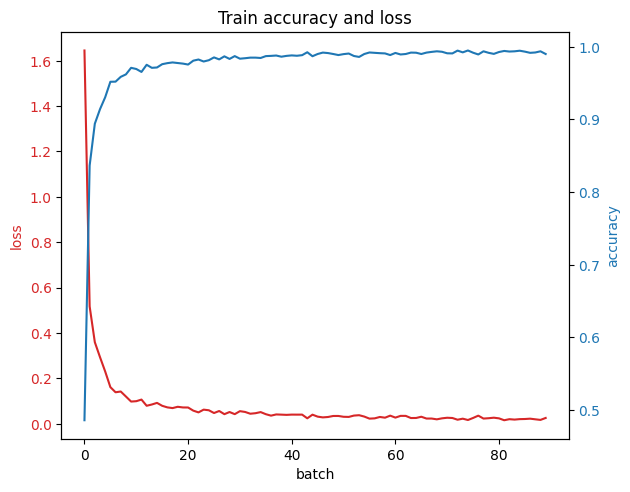

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Train accuracy and loss')
plt.show()


In [10]:
import pandas as pd
from torchmetrics import classification as metrics

accuracy = metrics.MulticlassAccuracy(num_classes=10, average=None).cuda()
precision = metrics.MulticlassPrecision(num_classes=10, average=None).cuda()
recall = metrics.MulticlassRecall(num_classes=10, average=None).cuda()

stats = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])


with torch.no_grad():

    for i in range(5):
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)

        
        stats_data = {'Accuracy': [accuracy.compute().cpu().numpy()],
              'Precision': [precision.compute().cpu().numpy()],
              'Recall': [recall.compute().cpu().numpy()]}

        stats = pd.concat([stats, pd.DataFrame(stats_data)], ignore_index=True)

        accuracy.reset()
        precision.reset()
        recall.reset()

# average across classes
stats.applymap(lambda x: np.mean(x)).style


,Accuracy,Precision,Recall
0,0.989040,0.989135,0.989040
1,0.989040,0.989135,0.989040
2,0.989040,0.989135,0.989040
3,0.989040,0.989135,0.989040
4,0.989040,0.989135,0.989040


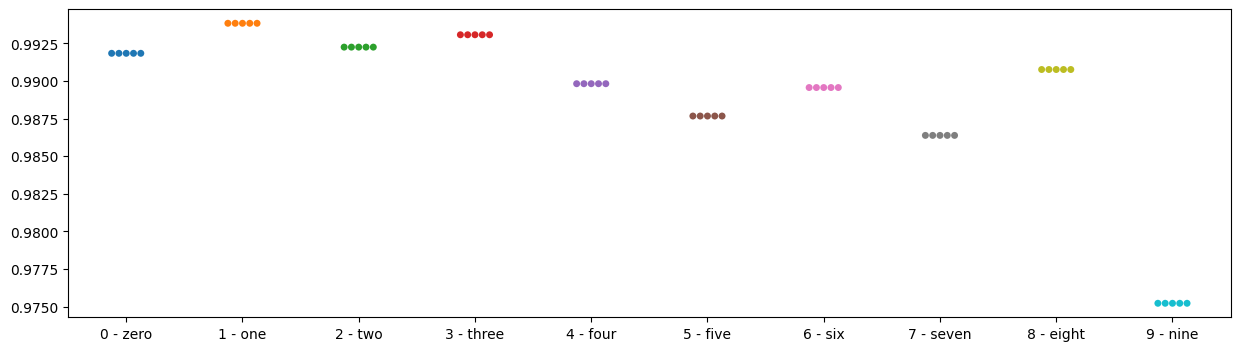

In [34]:
import seaborn as sns

df_mc = pd.DataFrame()

for i, label in enumerate(testset.classes):
    df_mc[label] = stats['Accuracy'].apply(lambda x: x[i])

sns.swarmplot(data=df_mc)
plt.gcf().set_size_inches(15, 4)
plt.show()


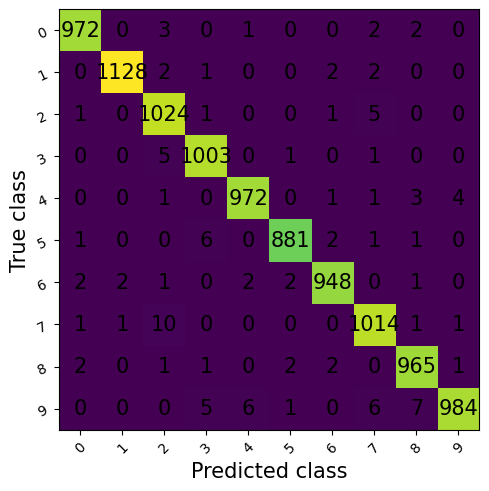

In [12]:
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix


confusion_matrix = MulticlassConfusionMatrix(num_classes=10).cuda()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        confusion_matrix(predicted, labels)

fig_, ax_ = confusion_matrix.plot()
plt.show()

### Fashion mnist

In [106]:
# download fashion mnist

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

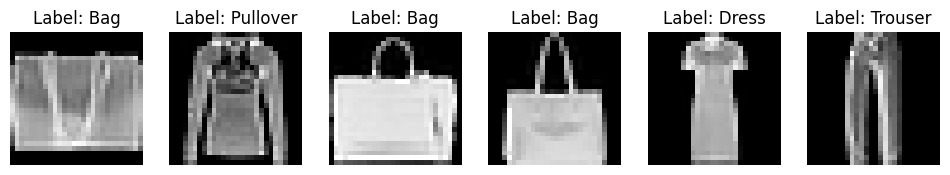

In [107]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = trainset.classes[labels[i].item()]
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

# Show the plot
plt.show()

In [108]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Define max pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # 7x7 image dimension after two max-pooling layers
        self.fc2 = nn.Linear(256, 10)  # Output 10 classes for Fashion MNIST

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Reshape the tensor for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [109]:
# train model

import torch.optim as optim
import torch.nn.functional as F

epochs = 10
print_every_n_batches = 50

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

accuracies = []
losses = []

for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                
                running_accuracy = running_loss = 0.0

[1,    50] loss: 1.139, accuracy: 0.601
[1,   100] loss: 0.647, accuracy: 0.765
[1,   150] loss: 0.573, accuracy: 0.791
[1,   200] loss: 0.493, accuracy: 0.816
[1,   250] loss: 0.484, accuracy: 0.819
[1,   300] loss: 0.445, accuracy: 0.844
[1,   350] loss: 0.430, accuracy: 0.847
[1,   400] loss: 0.409, accuracy: 0.852
[1,   450] loss: 0.409, accuracy: 0.848
[1,   500] loss: 0.394, accuracy: 0.866
[1,   550] loss: 0.395, accuracy: 0.855
[1,   600] loss: 0.351, accuracy: 0.876
[1,   650] loss: 0.353, accuracy: 0.874
[1,   700] loss: 0.352, accuracy: 0.868
[1,   750] loss: 0.355, accuracy: 0.870
[1,   800] loss: 0.351, accuracy: 0.873
[1,   850] loss: 0.347, accuracy: 0.872
[1,   900] loss: 0.340, accuracy: 0.885
[2,    50] loss: 0.331, accuracy: 0.877
[2,   100] loss: 0.299, accuracy: 0.888
[2,   150] loss: 0.305, accuracy: 0.883
[2,   200] loss: 0.306, accuracy: 0.891
[2,   250] loss: 0.304, accuracy: 0.893
[2,   300] loss: 0.280, accuracy: 0.900
[2,   350] loss: 0.311, accuracy: 0.876


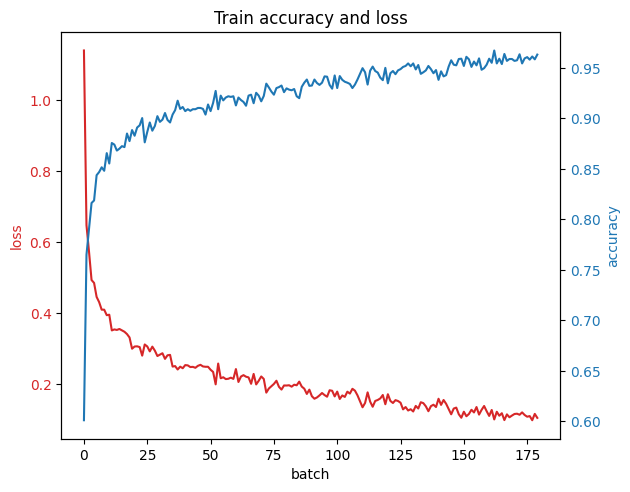

In [114]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Train accuracy and loss')
plt.show()


In [115]:
import pandas as pd
from torchmetrics import classification as metrics

accuracy = metrics.MulticlassAccuracy(num_classes=len(testset.classes), average=None).cuda()
precision = metrics.MulticlassPrecision(num_classes=len(testset.classes), average=None).cuda()
recall = metrics.MulticlassRecall(num_classes=len(testset.classes), average=None).cuda()

stats = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])


with torch.no_grad():

    for i in range(5):
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)

        stats_data = {'Accuracy': [accuracy.compute().cpu().numpy()],
              'Precision': [precision.compute().cpu().numpy()],
              'Recall': [recall.compute().cpu().numpy()]}

        stats = pd.concat([stats, pd.DataFrame(stats_data)], ignore_index=True)

        accuracy.reset()
        precision.reset()
        recall.reset()

# average across classes
stats.applymap(lambda x: np.mean(x)).style


,Accuracy,Precision,Recall
0,0.917800,0.918556,0.917800
1,0.917800,0.918556,0.917800
2,0.917800,0.918556,0.917800
3,0.917800,0.918556,0.917800
4,0.917800,0.918556,0.917800


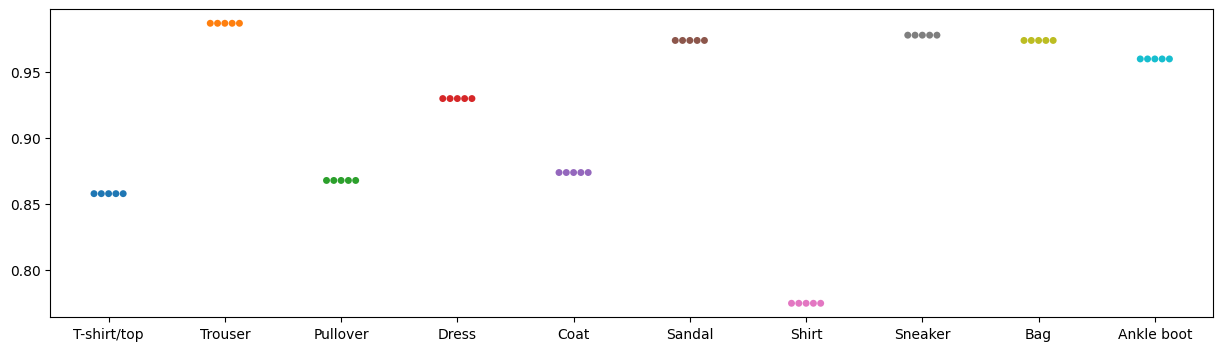

In [116]:
import seaborn as sns

df_mc = pd.DataFrame()

for i, label in enumerate(testset.classes):
    df_mc[label] = stats['Accuracy'].apply(lambda x: x[i])

sns.swarmplot(data=df_mc)
plt.gcf().set_size_inches(15, 4)
plt.show()


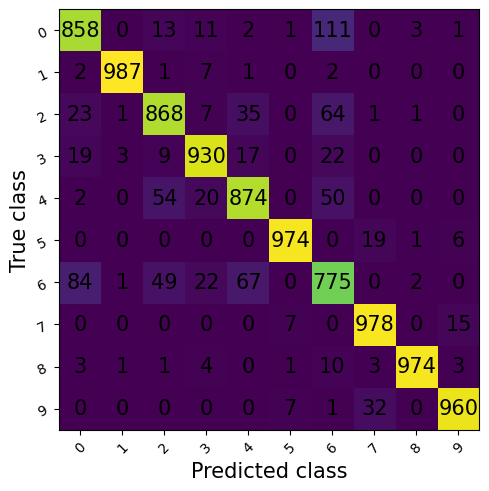

In [117]:
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix


confusion_matrix = MulticlassConfusionMatrix(num_classes=10).cuda()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        confusion_matrix(predicted, labels)

fig_, ax_ = confusion_matrix.plot()
plt.show()

### CIFAR-100

In [118]:
# download cifar10

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13151375.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


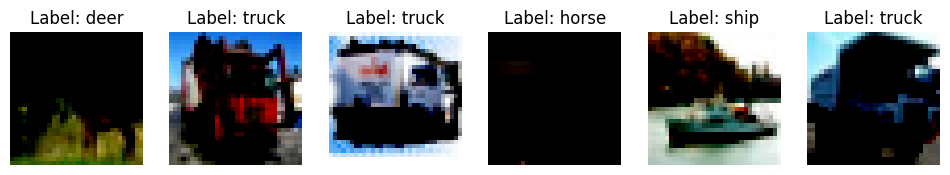

In [127]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = trainset.classes[labels[i].item()]

    axes[i].imshow(image.transpose(1, 2, 0))
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
    

# Show the plot
plt.show()

In [128]:
# define model

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Define max pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # 8x8 image dimension after two max-pooling layers
        self.fc2 = nn.Linear(256, 10)  # Output 10 classes for CIFAR10

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Reshape the tensor for fully connected layers
        x = x.view(-1, 64 * 8 * 8)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [129]:
# train model

import torch.optim as optim
import torch.nn.functional as F

epochs = 10
print_every_n_batches = 50

net = Net().cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

accuracies = []
losses = []

for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                
                running_accuracy = running_loss = 0.0

[1,    50] loss: 2.017, accuracy: 0.269
[1,   100] loss: 1.677, accuracy: 0.392
[1,   150] loss: 1.510, accuracy: 0.466
[1,   200] loss: 1.456, accuracy: 0.464
[1,   250] loss: 1.388, accuracy: 0.510
[1,   300] loss: 1.305, accuracy: 0.525
[1,   350] loss: 1.287, accuracy: 0.530
[1,   400] loss: 1.273, accuracy: 0.551
[1,   450] loss: 1.275, accuracy: 0.547
[1,   500] loss: 1.166, accuracy: 0.591
[1,   550] loss: 1.191, accuracy: 0.590
[1,   600] loss: 1.149, accuracy: 0.582
[1,   650] loss: 1.168, accuracy: 0.579
[1,   700] loss: 1.083, accuracy: 0.613
[1,   750] loss: 1.096, accuracy: 0.606
[2,    50] loss: 1.031, accuracy: 0.629
[2,   100] loss: 1.011, accuracy: 0.641
[2,   150] loss: 1.019, accuracy: 0.644
[2,   200] loss: 0.974, accuracy: 0.660
[2,   250] loss: 1.000, accuracy: 0.643
[2,   300] loss: 0.956, accuracy: 0.671
[2,   350] loss: 0.975, accuracy: 0.662
[2,   400] loss: 0.948, accuracy: 0.664
[2,   450] loss: 0.985, accuracy: 0.649
[2,   500] loss: 0.943, accuracy: 0.660


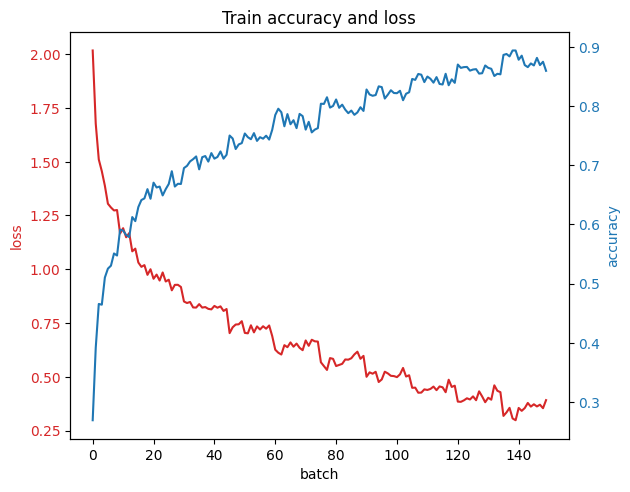

In [130]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batch')
ax1.set_ylabel('loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Train accuracy and loss')
plt.show()


In [131]:
import pandas as pd
from torchmetrics import classification as metrics

accuracy = metrics.MulticlassAccuracy(num_classes=len(testset.classes), average=None).cuda()
precision = metrics.MulticlassPrecision(num_classes=len(testset.classes), average=None).cuda()
recall = metrics.MulticlassRecall(num_classes=len(testset.classes), average=None).cuda()

stats = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall'])


with torch.no_grad():

    for i in range(5):
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            accuracy.update(outputs, labels)
            precision.update(outputs, labels)
            recall.update(outputs, labels)

        stats_data = {'Accuracy': [accuracy.compute().cpu().numpy()],
              'Precision': [precision.compute().cpu().numpy()],
              'Recall': [recall.compute().cpu().numpy()]}

        stats = pd.concat([stats, pd.DataFrame(stats_data)], ignore_index=True)

        accuracy.reset()
        precision.reset()
        recall.reset()

# average across classes
stats.applymap(lambda x: np.mean(x)).style

,Accuracy,Precision,Recall
0,0.746500,0.750195,0.746500
1,0.746500,0.750195,0.746500
2,0.746500,0.750195,0.746500
3,0.746500,0.750195,0.746500
4,0.746500,0.750195,0.746500


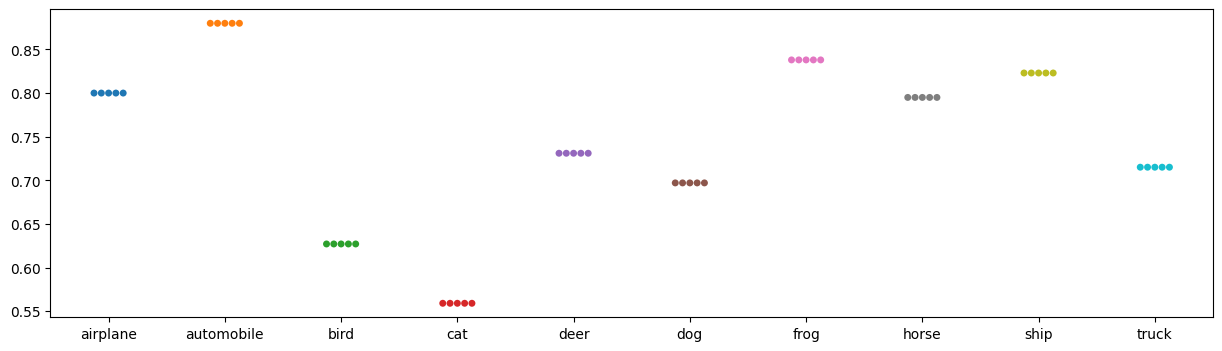

In [132]:
import seaborn as sns

df_mc = pd.DataFrame()

for i, label in enumerate(testset.classes):
    df_mc[label] = stats['Accuracy'].apply(lambda x: x[i])

sns.swarmplot(data=df_mc)
plt.gcf().set_size_inches(15, 4)
plt.show()


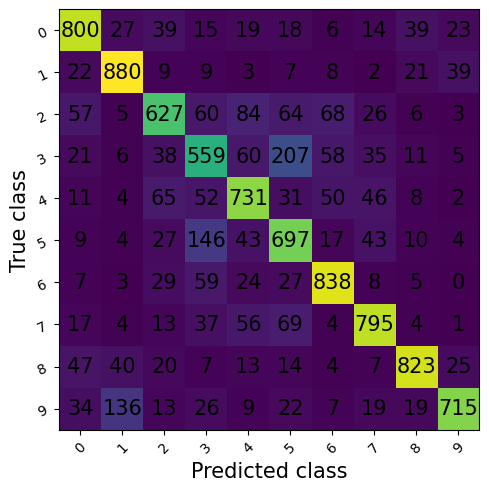

In [133]:
from torch import randint
from torchmetrics.classification import MulticlassConfusionMatrix


confusion_matrix = MulticlassConfusionMatrix(num_classes=10).cuda()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        confusion_matrix(predicted, labels)

fig_, ax_ = confusion_matrix.plot()
plt.show()